import pandas as pd

df = pd.read_csv("cic_ids_smote03.csv")

In [1]:
import pandas as pd

df = pd.read_csv("D:/dataset/cleaned_improved_cicids2017.csv")

In [2]:
df['Label'].value_counts()

BENIGN                        1594540
Portscan                       159066
DoS Hulk                       158468
DDoS                            95144
Infiltration - Portscan         71767
DoS GoldenEye                    7567
FTP-Patator                      3972
DoS Slowloris                    3859
SSH-Patator                      2961
DoS Slowhttptest                 1740
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: Label, dtype: int64

BENIGN                        1594540<br>
Portscan                       159066<br>
DoS Hulk                       158468<br>
DDoS                            95144<br>
Infiltration - Portscan         71767<br>
DoS GoldenEye                    7567<br>
FTP-Patator                      3972<br>
DoS Slowloris                    3859<br>
SSH-Patator                      2961<br>
DoS Slowhttptest                 1740<br>
Botnet                            736<br>
Web Attack - Brute Force           73<br>
Infiltration                       36<br>
Web Attack - XSS                   18<br>
Web Attack - SQL Injection         13<br>
Heartbleed                         11<br>

In [3]:
# 이진분류
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

# 변경된 데이터프레임 확인
print(df.head())

   Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0         0      119719148               231                  0   
1        17       65511209                 6                  6   
2        17      113976922               267                  0   
3        17       67037196                 8                  8   
4        17       68045057                 8                  8   

   Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                           0                           0   
1                         288                         288   
2                       20447                           0   
3                         384                         384   
4                         384                         384   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                      0                      0                0.000000   
1                     48                     48               48.000000   
2    

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

tmp = df.drop(labels = 'Label',axis=1)

# 1. 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tmp)

# 2. PCA 적용 (주성분 개수 설정)
n_components = 25  # 원하는 차원 수로 설정
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)



# 변환된 데이터 확인
print(f'Original shape: {df.shape}')
print(f'Transformed shape (PCA applied): {X_pca.shape}')

# X_pca를 DataFrame으로 변환
X_pca_df = pd.DataFrame(X_pca)

# `assign`으로 label 추가
df_merged = X_pca_df.assign(label=df['Label'].values)

Original shape: (2099971, 83)
Transformed shape (PCA applied): (2099971, 25)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df_merged, test_size=0.1, random_state=42)
X_train.shape, X_test.shape

((1889973, 26), (209998, 26))

In [6]:
X_train_normal = X_train[X_train['label'] == 0]
X_train_normal.shape

X_test_normal = X_test[X_test['label'] == 0]
X_test_normal.shape

(159227, 26)

In [7]:
X_train_not_normal = X_train[X_train['label'] !=0]

X_test = pd.concat([X_test, X_train_not_normal])

In [8]:
y_test = X_test['label']
X_test = X_test.drop(labels='label',axis=1)
y_train_normal = X_train_normal['label']
X_train_normal = X_train_normal.drop(labels='label', axis=1)

In [9]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input
import numpy as np
from tensorflow.keras import backend as K

latent_dim = 10
inter_dim = 20

# Sampling function for reparameterization trick
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean), axis=1)
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    kl_loss_weighted = kl_loss * 0.001  # KL 다이버전스 손실에 가중치 부여
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
    return total_loss

def cvae(X, labels):
    features = X.shape[1]  # 2D 데이터이므로 timesteps는 필요 없고, features만 사용
    input_x = Input(shape=(features,), name='InputFeatures')  # 2D 입력 (샘플, 특징)

    input_label = Input(shape=(1,), name='InputLabel')  # Assumes binary or multi-class label

    # Embed the label into the same shape as the input
    embedded_label = layers.Embedding(input_dim=2, output_dim=features)(input_label)  # Adjust output_dim to match features
    embedded_label = layers.Flatten()(embedded_label)

    # Concatenate input_x and embedded_label
    concatenated_input = layers.Concatenate()([input_x, embedded_label])

    # Reshape for Conv1D layer (to 3D)
    reshaped_input = layers.Reshape((features + embedded_label.shape[-1], 1))(concatenated_input)

    # Encoder with CNN layers
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)

    # Flatten for dense layers (MLP)
    h = layers.Flatten()(h)
    h = layers.Dense(inter_dim, activation='relu')(h)
    h = layers.Dense(inter_dim, activation='relu')(h)

    # z layer
    z_mean = layers.Dense(latent_dim)(h)
    z_log_sigma = layers.Dense(latent_dim)(h)
    z = layers.Lambda(sampling)([z_mean, z_log_sigma])

    # Decoder
    # Add the label to the latent space z
    z_with_label = layers.Concatenate()([z, embedded_label])

    # Expand for Conv1DTranspose layer
    decoder1 = layers.Dense((features + embedded_label.shape[-1]) * inter_dim)(z_with_label)
    decoder1 = layers.Reshape((features + embedded_label.shape[-1], inter_dim))(decoder1)

    # Decoder with CNN layers
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)

    # Flatten and final dense layer to reconstruct original features
    decoder1 = layers.Flatten()(decoder1)
    decoder1 = layers.Dense(features)(decoder1)
    
    model = Model([input_x, input_label], decoder1)
    model.add_loss(vae_loss(input_x, decoder1, z_mean, z_log_sigma))
    
    return model

# Create CVAE model
model = cvae(X_train_normal, y_train_normal)
model.summary()

from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile and train the model with early stopping
history = model.fit([X_train_normal, y_train_normal], X_train_normal,
                    shuffle=True,
                    epochs=50, 
                    validation_split=0.1,  
                    batch_size=32,
                    callbacks=[early_stopping]).history

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLabel (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 25)        50          ['InputLabel[0][0]']             
                                                                                                  
 InputFeatures (InputLayer)     [(None, 25)]         0           []                               
                                                                                                  
 flatten (Flatten)              (None, 25)           0           ['embedding[0][0]']              
                                                                                              

                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None,)             0           ['tf.math.reduce_sum[0][0]',     
 mbda)                                                            'tf.math.multiply_1[0][0]']     
                                                                                                  
 tf.math.reduce_mean (TFOpLambd  ()                  0           ['tf.__operators__.add_1[0][0]'] 
 a)                                                                                               
                                                                                                  
 add_loss (AddLoss)             ()                   0           ['tf.math.reduce_mean[0][0]']    
                                                                                                  
Total params: 149,671
Trainable params: 149,671
Non-trainable params: 0
_____________________________________

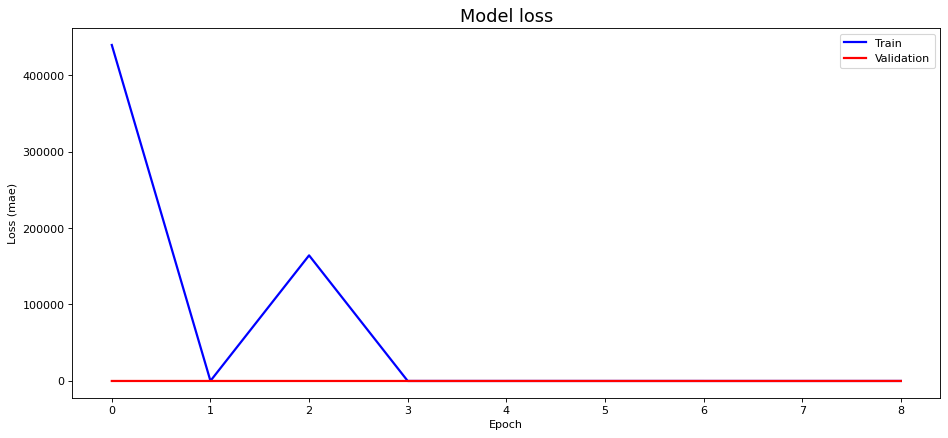

In [11]:
import matplotlib.pyplot as plt

# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [12]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [13]:
valid_x_predictions = model.predict([X_test, y_test])
#mse = np.mean(np.power(flatten(test_X_selected) - flatten(valid_x_predictions), 2), axis=1)

mse = np.mean(np.power(X_test - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test.tolist()})

20771/20771 [==============================] - 102s 5ms/step


In [14]:
error_df

,reconstruction_error,true_class
464355,0.001951,0
660360,0.829677,1
1411149,0.034324,0
2022900,0.000962,0
672693,0.164609,0
...,...,...
1825573,3.759378,1
1370455,0.707894,1
787201,0.637499,1
2003274,0.659330,1


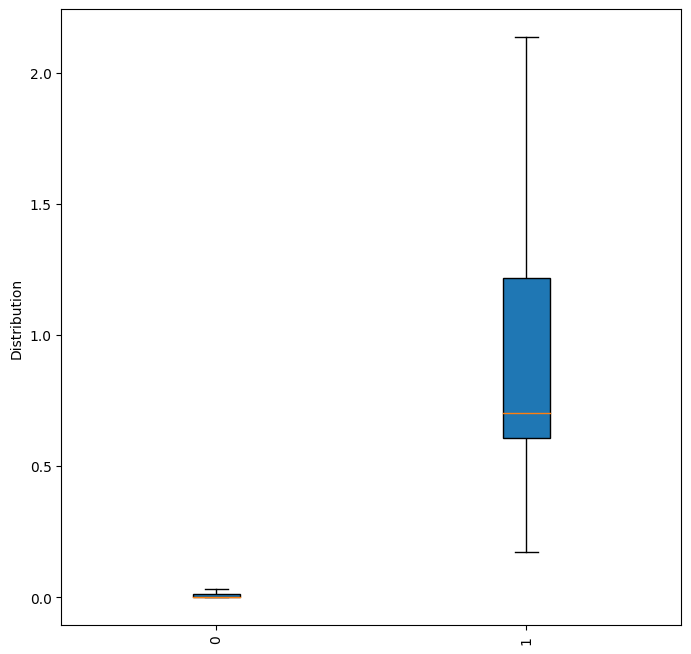

In [15]:
import matplotlib.pyplot as plt

# 데이터프레임 준비
true_class = error_df['true_class'].astype(str)
reconstruction_error = error_df['reconstruction_error']

# 박스 플롯 그리기
plt.figure(figsize=(8, 8))
plt.boxplot(
    [reconstruction_error[true_class == cls] for cls in sorted(true_class.unique())],
    labels=sorted(true_class.unique()),
    showfliers=False,
    vert=True,
    patch_artist=True
)

plt.ylabel('Distribution')
plt.xticks(rotation=90)
plt.show()


Best threshold: 0.27
Best F1 score: 0.997197370264888


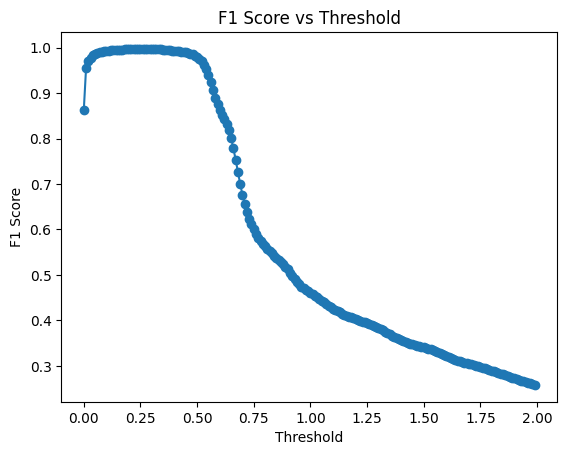

In [17]:
import numpy as np
from sklearn.metrics import f1_score

# Define the range of threshold values
threshold_range = np.arange(0, 2.0, 0.01)

# List to store F1 scores for each threshold
f1_scores = []

# Loop through each threshold and calculate F1 score
for threshold in threshold_range:
    y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
    f1 = f1_score(error_df.true_class, y_pred)
    f1_scores.append(f1)

# Find the threshold with the highest F1 score
best_threshold = threshold_range[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best threshold: {best_threshold}")
print(f"Best F1 score: {best_f1_score}")

# Optionally, you can plot the F1 scores across the threshold range
plt.plot(threshold_range, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.show()

In [22]:
threshold = best_threshold

<Figure size 1200x1200 with 0 Axes>

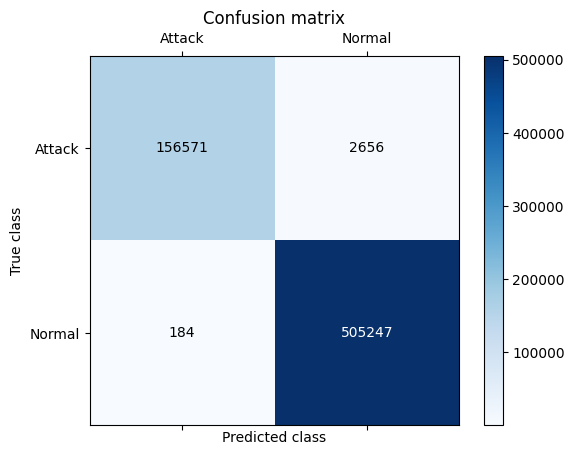

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have already defined LABELS, threshold, and y_pred

LABELS = ["Attack", "Normal"]

y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

# Create the figure and axis
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots()

# Plot the confusion matrix using imshow
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Set the labels for the axes
ax.set_xticks(np.arange(len(LABELS)))
ax.set_yticks(np.arange(len(LABELS)))

ax.set_xticklabels(LABELS)
ax.set_yticklabels(LABELS)

# Set labels and title
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix')

# Annotate the confusion matrix with the counts
for i in range(len(LABELS)):
    for j in range(len(LABELS)):
        ax.text(j, i, format(conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

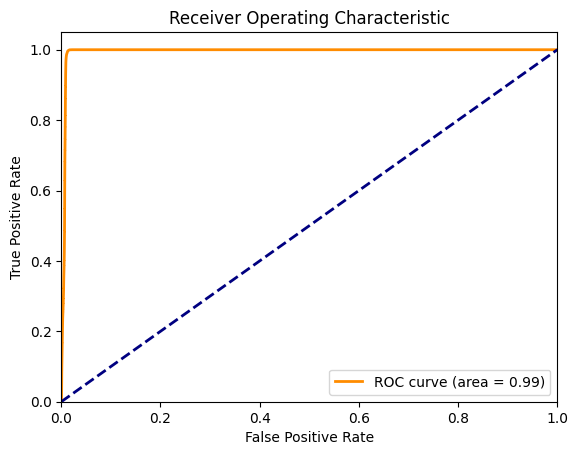

In [24]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and reconstruction_error have been defined
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [25]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.9957271258301261
Precision : 0.9947706550266487
Recall : 0.999635954264776
F1 : 0.997197370264888


In [26]:
print(f"ROC Score : {roc_auc}")

ROC Score : 0.994345203703309
